<a href="https://colab.research.google.com/github/Ebad-urRehman/MAHED_2025_subtask1_hate_and_hope/blob/main/notebooks/hope_hate_speech_Meta_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Meta classifier stack optimized models



In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import json, re, nltk, numpy as np
nltk.download('stopwords')
from nltk.corpus import stopwords

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Load Data
df = pd.read_csv("/content/drive/MyDrive/colab_data/files/train.csv")
texts_raw = df["text"].astype(str).tolist()
labels = df["label"].map({"hope": 0, "hate": 1, "not_applicable": 2}).tolist()

#  Preprocessing
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))

def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda match: emoji_to_arabic.get(match.group(0), match.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def clean_text(text):
    text = text.strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text

texts = [clean_text(t) for t in texts_raw]

# Binary label split
labels_hope = [1 if y == 0 else 0 for y in labels]  # hope vs others
labels_hate = [1 if y == 1 else 0 for y in labels]  # hate vs others

#  Dataset
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

class ArabicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

#  Model
class BertBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

#  Training Function
def train_binary_model(texts, binary_labels, label_name=""):
    X_train, X_val, y_train, y_val = train_test_split(
        texts, binary_labels, test_size=0.2, stratify=binary_labels, random_state=42
    )

    train_ds = ArabicDataset(X_train, y_train, tokenizer)
    val_ds = ArabicDataset(X_val, y_val, tokenizer)
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=16)

    model = BertBinaryClassifier().to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    # Train loop
    for epoch in range(8):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attn = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attn)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # epoch summary
        print(f"[{label_name}] Epoch {epoch+1}/{8} "
              f"| Avg Loss: {total_loss/len(train_loader):.4f} "
              f"| Accuracy: {correct/total:.4f}")
        print(f"[{label_name}] Epoch {epoch+1} | Loss: {total_loss:.4f} | Acc: {correct/total:.4f}")

    # Validation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attn = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attn)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(f"\n📊 {label_name} Classification Report")
    print(classification_report(all_labels, all_preds, digits=3))
    return model

#  Train hope vs not_applicable
print("Training Hope Classifier...")
model_hope = train_binary_model(texts, labels_hope, label_name="Hope")

#  Train hate vs not_applicable
print("Training Hate Classifier...")
model_hate = train_binary_model(texts, labels_hate, label_name="Hate")

#  Get Model Probabilities
def get_model_probs(model, texts):
    dataset = ArabicDataset(texts, [0]*len(texts), tokenizer)
    loader = DataLoader(dataset, batch_size=16)
    model.eval()
    probs_all = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            outputs = model(input_ids, attn)
            probs = torch.softmax(outputs, dim=1)
            probs_all.extend(probs.cpu().numpy())
    return np.array(probs_all)

hope_logits = get_model_probs(model_hope, texts)
hate_logits = get_model_probs(model_hate, texts)
meta_features = np.concatenate([hope_logits, hate_logits], axis=1)

#  Meta Classifier
print("Training Meta Classifier...")
X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(
    meta_features, labels, test_size=0.2, stratify=labels, random_state=42
)

meta_clf = LogisticRegression(max_iter=200)
meta_clf.fit(X_train_meta, y_train_meta)

y_pred_meta = meta_clf.predict(X_val_meta)
print("\nMeta Classifier Performance:")
print(classification_report(y_val_meta, y_pred_meta, target_names=["hope", "hate", "not_applicable"], digits=3))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Training Hope Classifier...


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

[Hope] Epoch 1/8 | Avg Loss: 0.4862 | Accuracy: 0.7674
[Hope] Epoch 1 | Loss: 167.7377 | Acc: 0.7674
[Hope] Epoch 2/8 | Avg Loss: 0.3792 | Accuracy: 0.8257
[Hope] Epoch 2 | Loss: 130.8389 | Acc: 0.8257
[Hope] Epoch 3/8 | Avg Loss: 0.2337 | Accuracy: 0.9008
[Hope] Epoch 3 | Loss: 80.6365 | Acc: 0.9008
[Hope] Epoch 4/8 | Avg Loss: 0.1322 | Accuracy: 0.9483
[Hope] Epoch 4 | Loss: 45.6184 | Acc: 0.9483
[Hope] Epoch 5/8 | Avg Loss: 0.0806 | Accuracy: 0.9693
[Hope] Epoch 5 | Loss: 27.7976 | Acc: 0.9693
[Hope] Epoch 6/8 | Avg Loss: 0.0460 | Accuracy: 0.9817
[Hope] Epoch 6 | Loss: 15.8579 | Acc: 0.9817
[Hope] Epoch 7/8 | Avg Loss: 0.0446 | Accuracy: 0.9837
[Hope] Epoch 7 | Loss: 15.3981 | Acc: 0.9837
[Hope] Epoch 8/8 | Avg Loss: 0.0488 | Accuracy: 0.9820
[Hope] Epoch 8 | Loss: 16.8213 | Acc: 0.9820

📊 Hope Classification Report
              precision    recall  f1-score   support

           0      0.839     0.820     0.830      1000
           1      0.551     0.585     0.567       378

    

# Meta classifier stack optimized models evaluation on validation.csv




📊 Hope Classifier Report:
              precision    recall  f1-score   support

    not_hope       0.87      0.91      0.89       967
        hope       0.81      0.73      0.77       509

    accuracy                           0.85      1476
   macro avg       0.84      0.82      0.83      1476
weighted avg       0.85      0.85      0.85      1476



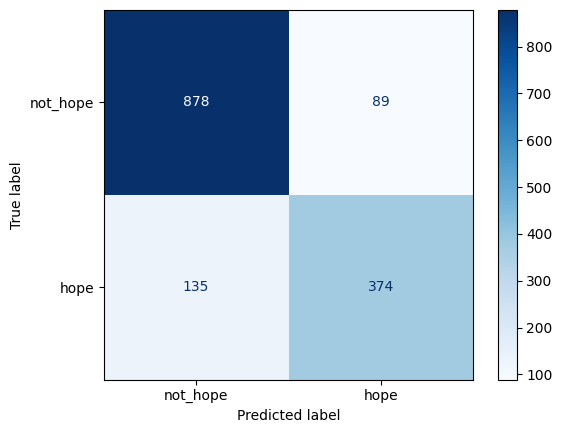


📊 Hate Classifier Report:
              precision    recall  f1-score   support

    not_hate       0.99      0.85      0.91      1318
        hate       0.43      0.93      0.58       158

    accuracy                           0.86      1476
   macro avg       0.71      0.89      0.75      1476
weighted avg       0.93      0.86      0.88      1476



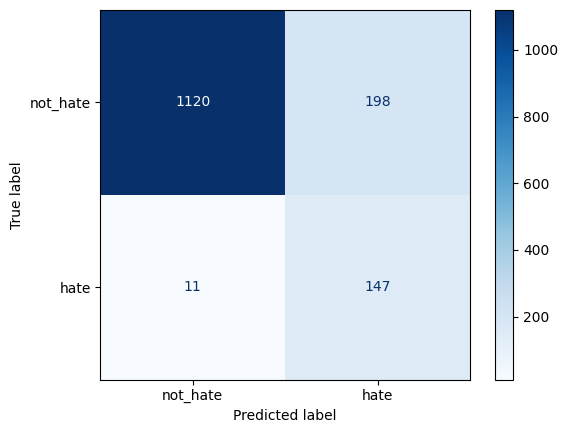


📊 Meta Classifier Report (Final Prediction):
                precision    recall  f1-score   support

          hope       0.82      0.71      0.76       509
          hate       0.46      0.91      0.61       158
not_applicable       0.80      0.71      0.76       809

      accuracy                           0.73      1476
     macro avg       0.69      0.78      0.71      1476
  weighted avg       0.77      0.73      0.74      1476



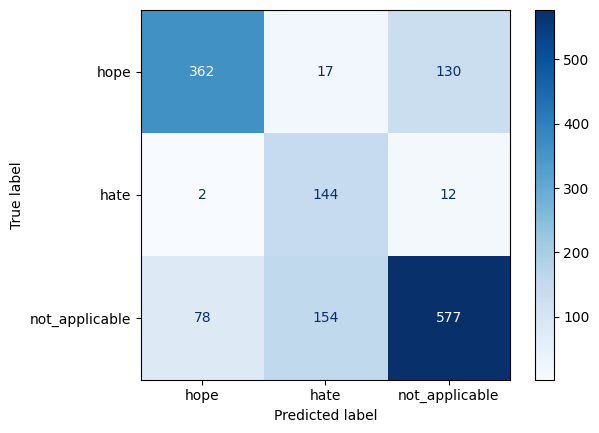

In [ ]:
import os, re, json, string, nltk
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import joblib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = "/content/drive/MyDrive/colab_data/new_for_research"
max_len = 128

#  Load Emoji Map
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))

#  Same Cleaning Functions as Training
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    return re.sub(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]", "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda m: emoji_to_arabic.get(m.group(0), m.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def clean_text(text):
    text = str(text).strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text

#  Dataset
class ArabicDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        texts = [clean_text(t) for t in texts]
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

#  Model (must match training)
class BertBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

#  Load Tokenizer & Models
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

model_hope_loaded = BertBinaryClassifier()
model_hope_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hope_classifier_new.pt"), map_location=device))
model_hope_loaded.to(device).eval()

model_hate_loaded = BertBinaryClassifier()
model_hate_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hate_classifier_new.pt"), map_location=device))
model_hate_loaded.to(device).eval()

meta_clf_loaded = joblib.load(os.path.join(save_dir, "meta_classifier_new.pkl"))

#  Function to Get Model Probabilities
def get_model_probs(model, texts):
    dataset = ArabicDataset(texts, tokenizer, max_len)
    loader = DataLoader(dataset, batch_size=16)
    probs_all = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            outputs = model(input_ids, attn)
            probs = torch.softmax(outputs, dim=1)
            probs_all.extend(probs.cpu().numpy())
    return np.array(probs_all)

#  Load Validation Data
val_df = pd.read_csv("/content/drive/MyDrive/colab_data/files/validation_predictions.csv")
val_df["text"] = val_df["text"].astype(str)

label_map = {"hope": 0, "hate": 1, "not_applicable": 2}
labels_val = val_df["predicted_label"].map(label_map).astype(int).tolist()

#  Run Models
hope_logits_val = get_model_probs(model_hope_loaded, val_df["text"].tolist())
hate_logits_val = get_model_probs(model_hate_loaded, val_df["text"].tolist())

meta_features_val = np.concatenate([hope_logits_val, hate_logits_val], axis=1)
y_pred_meta = meta_clf_loaded.predict(meta_features_val)

#  Reports
print("\n📊 Hope Classifier Report:")
y_pred_hope = np.argmax(hope_logits_val, axis=1)
y_true_hope = [1 if l == 0 else 0 for l in labels_val]
print(classification_report(y_true_hope, y_pred_hope, target_names=["not_hope", "hope"]))
ConfusionMatrixDisplay(confusion_matrix(y_true_hope, y_pred_hope),
                       display_labels=["not_hope", "hope"]).plot(cmap=plt.cm.Blues)
plt.show()

print("\n📊 Hate Classifier Report:")
y_pred_hate = np.argmax(hate_logits_val, axis=1)
y_true_hate = [1 if l == 1 else 0 for l in labels_val]
print(classification_report(y_true_hate, y_pred_hate, target_names=["not_hate", "hate"]))
ConfusionMatrixDisplay(confusion_matrix(y_true_hate, y_pred_hate),
                       display_labels=["not_hate", "hate"]).plot(cmap=plt.cm.Blues)
plt.show()

print("\n📊 Meta Classifier Report (Final Prediction):")
print(classification_report(labels_val, y_pred_meta, target_names=["hope", "hate", "not_applicable"]))
ConfusionMatrixDisplay(confusion_matrix(labels_val, y_pred_meta),
                       display_labels=["hope", "hate", "not_applicable"]).plot(cmap=plt.cm.Blues)
plt.show()


# Meta classifier stack optimized models evaluation on test.csv




📊 Hope Classifier Report:
              precision    recall  f1-score   support

    not_hope       0.86      0.81      0.83      1055
        hope       0.58      0.68      0.63       422

    accuracy                           0.77      1477
   macro avg       0.72      0.74      0.73      1477
weighted avg       0.78      0.77      0.77      1477



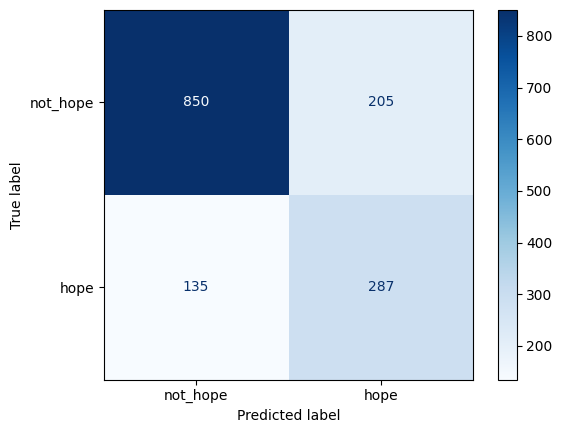


📊 Hate Classifier Report:
              precision    recall  f1-score   support

    not_hate       0.92      0.87      0.90      1190
        hate       0.56      0.70      0.63       287

    accuracy                           0.84      1477
   macro avg       0.74      0.79      0.76      1477
weighted avg       0.85      0.84      0.84      1477



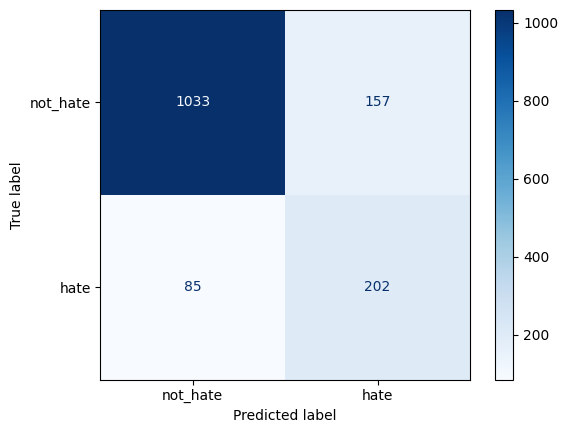


📊 Meta Classifier Report (Final Prediction):
                precision    recall  f1-score   support

          hope       0.58      0.67      0.62       422
          hate       0.58      0.67      0.62       287
not_applicable       0.69      0.60      0.64       768

      accuracy                           0.63      1477
     macro avg       0.62      0.64      0.63      1477
  weighted avg       0.64      0.63      0.63      1477



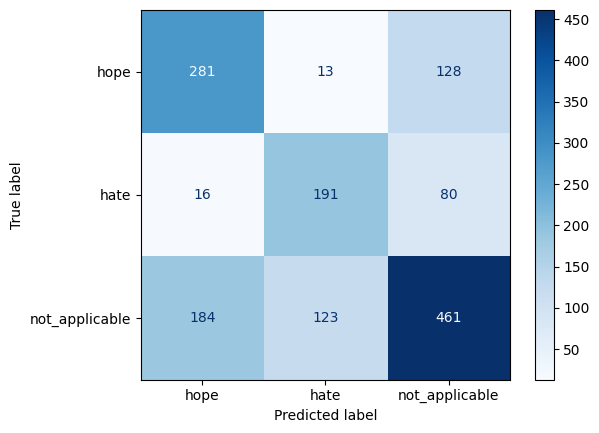

In [ ]:
import os, re, json, string, nltk
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import joblib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = "/content/drive/MyDrive/colab_data/new_for_research"
max_len = 128

#  Load Emoji Map
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))

#  Same Cleaning Functions as Training
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    return re.sub(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]", "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda m: emoji_to_arabic.get(m.group(0), m.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def clean_text(text):
    text = str(text).strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text

#  Dataset
class ArabicDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        texts = [clean_text(t) for t in texts]
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

#  Model (must match training)
class BertBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

#  Load Tokenizer & Models
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

model_hope_loaded = BertBinaryClassifier()
model_hope_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hope_classifier_new.pt"), map_location=device))
model_hope_loaded.to(device).eval()

model_hate_loaded = BertBinaryClassifier()
model_hate_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hate_classifier_new.pt"), map_location=device))
model_hate_loaded.to(device).eval()

meta_clf_loaded = joblib.load(os.path.join(save_dir, "meta_classifier_new.pkl"))

#  Function to Get Model Probabilities
def get_model_probs(model, texts):
    dataset = ArabicDataset(texts, tokenizer, max_len)
    loader = DataLoader(dataset, batch_size=16)
    probs_all = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            outputs = model(input_ids, attn)
            probs = torch.softmax(outputs, dim=1)
            probs_all.extend(probs.cpu().numpy())
    return np.array(probs_all)

#  Load Validation Data
val_df = pd.read_csv("/content/drive/MyDrive/colab_data/files/test.csv")
val_df["text"] = val_df["text"].astype(str)

label_map = {"hope": 0, "hate": 1, "not_applicable": 2}
labels_val = val_df["label"].map(label_map).astype(int).tolist()

#  Run Models
hope_logits_val = get_model_probs(model_hope_loaded, val_df["text"].tolist())
hate_logits_val = get_model_probs(model_hate_loaded, val_df["text"].tolist())

meta_features_val = np.concatenate([hope_logits_val, hate_logits_val], axis=1)
y_pred_meta = meta_clf_loaded.predict(meta_features_val)

#  Reports
print("\n📊 Hope Classifier Report:")
y_pred_hope = np.argmax(hope_logits_val, axis=1)
y_true_hope = [1 if l == 0 else 0 for l in labels_val]
print(classification_report(y_true_hope, y_pred_hope, target_names=["not_hope", "hope"]))
ConfusionMatrixDisplay(confusion_matrix(y_true_hope, y_pred_hope),
                       display_labels=["not_hope", "hope"]).plot(cmap=plt.cm.Blues)
plt.show()

print("\n📊 Hate Classifier Report:")
y_pred_hate = np.argmax(hate_logits_val, axis=1)
y_true_hate = [1 if l == 1 else 0 for l in labels_val]
print(classification_report(y_true_hate, y_pred_hate, target_names=["not_hate", "hate"]))
ConfusionMatrixDisplay(confusion_matrix(y_true_hate, y_pred_hate),
                       display_labels=["not_hate", "hate"]).plot(cmap=plt.cm.Blues)
plt.show()

print("\n📊 Meta Classifier Report (Final Prediction):")
print(classification_report(labels_val, y_pred_meta, target_names=["hope", "hate", "not_applicable"]))
ConfusionMatrixDisplay(confusion_matrix(labels_val, y_pred_meta),
                       display_labels=["hope", "hate", "not_applicable"]).plot(cmap=plt.cm.Blues)
plt.show()

# Meta classifier stack optimized models |  without emojis

In [ ]:
#  FULL PIPELINE: Binary Hope + Hate Classifiers
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import json, re, nltk, numpy as np
nltk.download('stopwords')
from nltk.corpus import stopwords

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Load Data
df = pd.read_csv("/content/drive/MyDrive/colab_data/files/test.csv")
texts_raw = df["text"].astype(str).tolist()
labels = df["label"].map({"hope": 0, "hate": 1, "not_applicable": 2}).tolist()

#  Preprocessing
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U00002700-\U000027BF"  # dingbats
    "\U0001F900-\U0001F9FF"  # supplemental symbols
    "\U00002600-\U000026FF"  # miscellaneous symbols
    "\U00002B00-\U00002BFF"  # arrows
    "]+",
    flags=re.UNICODE
)

def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)


def remove_emojis(text):
    return emoji_pattern.sub(r'', text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def clean_text(text):
    text = text.strip()
    text = remove_emojis(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text

texts = [clean_text(t) for t in texts_raw]

# Binary label split
labels_hope = [1 if y == 0 else 0 for y in labels]  # hope vs others
labels_hate = [1 if y == 1 else 0 for y in labels]  # hate vs others

#  Dataset
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

class ArabicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

#  Model
class BertBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

#  Training Function
def train_binary_model(texts, binary_labels, label_name=""):
    X_train, X_val, y_train, y_val = train_test_split(
        texts, binary_labels, test_size=0.2, stratify=binary_labels, random_state=42
    )

    train_ds = ArabicDataset(X_train, y_train, tokenizer)
    val_ds = ArabicDataset(X_val, y_val, tokenizer)
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=16)

    model = BertBinaryClassifier().to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    # Train loop
    for epoch in range(8):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attn = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attn)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # epoch summary
        print(f"[{label_name}] Epoch {epoch+1}/{8} "
              f"| Avg Loss: {total_loss/len(train_loader):.4f} "
              f"| Accuracy: {correct/total:.4f}")
        print(f"[{label_name}] Epoch {epoch+1} | Loss: {total_loss:.4f} | Acc: {correct/total:.4f}")

    # Validation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attn = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attn)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(f"\n📊 {label_name} Classification Report")
    print(classification_report(all_labels, all_preds, digits=3))
    return model

#  Train hope vs not_applicable
print("Training Hope Classifier...")
model_hope = train_binary_model(texts, labels_hope, label_name="Hope")

#  Train hate vs not_applicable
print("Training Hate Classifier...")
model_hate = train_binary_model(texts, labels_hate, label_name="Hate")

#  Get Model Probabilities
def get_model_probs(model, texts):
    dataset = ArabicDataset(texts, [0]*len(texts), tokenizer)
    loader = DataLoader(dataset, batch_size=16)
    model.eval()
    probs_all = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            outputs = model(input_ids, attn)
            probs = torch.softmax(outputs, dim=1)
            probs_all.extend(probs.cpu().numpy())
    return np.array(probs_all)

hope_logits = get_model_probs(model_hope, texts)
hate_logits = get_model_probs(model_hate, texts)
meta_features = np.concatenate([hope_logits, hate_logits], axis=1)

#  Meta Classifier
print("Training Meta Classifier...")
X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(
    meta_features, labels, test_size=0.2, stratify=labels, random_state=42
)

meta_clf = LogisticRegression(max_iter=200)
meta_clf.fit(X_train_meta, y_train_meta)

y_pred_meta = meta_clf.predict(X_val_meta)
print("\nMeta Classifier Performance:")
print(classification_report(y_val_meta, y_pred_meta, target_names=["hope", "hate", "not_applicable"], digits=3))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Training Hope Classifier...


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

[Hope] Epoch 1/8 | Avg Loss: 0.5321 | Accuracy: 0.7282
[Hope] Epoch 1 | Loss: 39.3772 | Acc: 0.7282
[Hope] Epoch 2/8 | Avg Loss: 0.3480 | Accuracy: 0.8467
[Hope] Epoch 2 | Loss: 25.7539 | Acc: 0.8467
[Hope] Epoch 3/8 | Avg Loss: 0.2154 | Accuracy: 0.9153
[Hope] Epoch 3 | Loss: 15.9430 | Acc: 0.9153
[Hope] Epoch 4/8 | Avg Loss: 0.1034 | Accuracy: 0.9619
[Hope] Epoch 4 | Loss: 7.6548 | Acc: 0.9619
[Hope] Epoch 5/8 | Avg Loss: 0.0552 | Accuracy: 0.9805
[Hope] Epoch 5 | Loss: 4.0841 | Acc: 0.9805
[Hope] Epoch 6/8 | Avg Loss: 0.0197 | Accuracy: 0.9941
[Hope] Epoch 6 | Loss: 1.4601 | Acc: 0.9941
[Hope] Epoch 7/8 | Avg Loss: 0.0196 | Accuracy: 0.9907
[Hope] Epoch 7 | Loss: 1.4501 | Acc: 0.9907
[Hope] Epoch 8/8 | Avg Loss: 0.0211 | Accuracy: 0.9932
[Hope] Epoch 8 | Loss: 1.5602 | Acc: 0.9932

📊 Hope Classification Report
              precision    recall  f1-score   support

           0      0.872     0.744     0.803       211
           1      0.534     0.729     0.617        85

    accurac

In [ ]:
import os

save_dir = "/content/drive/MyDrive/colab_data/new_for_research"
os.makedirs(save_dir, exist_ok=True)


# Save BERT-based binary classifiers
torch.save(model_hope.state_dict(), os.path.join(save_dir, "hope_classifier_meta_without_emoji.pt"))
torch.save(model_hate.state_dict(), os.path.join(save_dir, "hate_classifier_meta_without_emoji.pt"))


import joblib

joblib.dump(meta_clf, os.path.join(save_dir, "meta_classifier_meta_without_emoji.pkl"))


['/content/drive/MyDrive/colab_data/new_for_research/meta_classifier_meta_without_emoji.pkl']

# Meta classifier stack optimized models |  without emojis evaluation on validation.csv


📊 Hope Classifier Report:
              precision    recall  f1-score   support

    not_hope       0.87      0.81      0.84       967
        hope       0.68      0.76      0.72       509

    accuracy                           0.79      1476
   macro avg       0.77      0.79      0.78      1476
weighted avg       0.80      0.79      0.80      1476



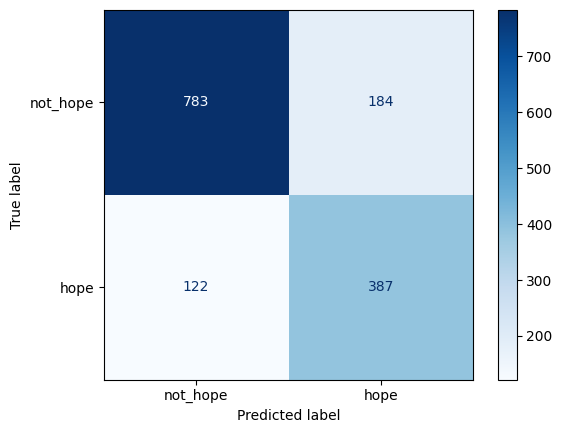


📊 Hate Classifier Report:
              precision    recall  f1-score   support

    not_hate       0.97      0.92      0.95      1318
        hate       0.55      0.77      0.64       158

    accuracy                           0.91      1476
   macro avg       0.76      0.85      0.79      1476
weighted avg       0.93      0.91      0.91      1476



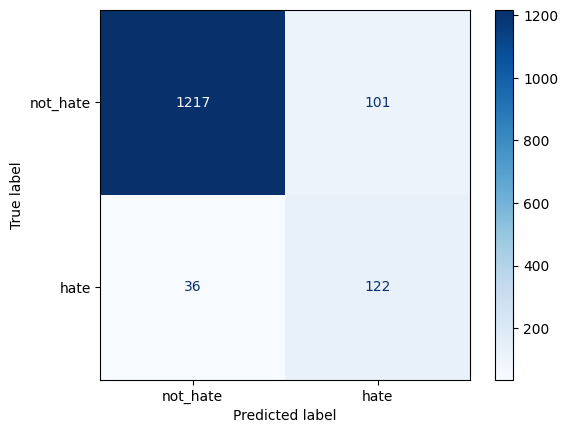


📊 Meta Classifier Report (Final Prediction):
                precision    recall  f1-score   support

          hope       0.69      0.74      0.71       509
          hate       0.56      0.76      0.65       158
not_applicable       0.77      0.69      0.73       809

      accuracy                           0.71      1476
     macro avg       0.67      0.73      0.70      1476
  weighted avg       0.72      0.71      0.71      1476



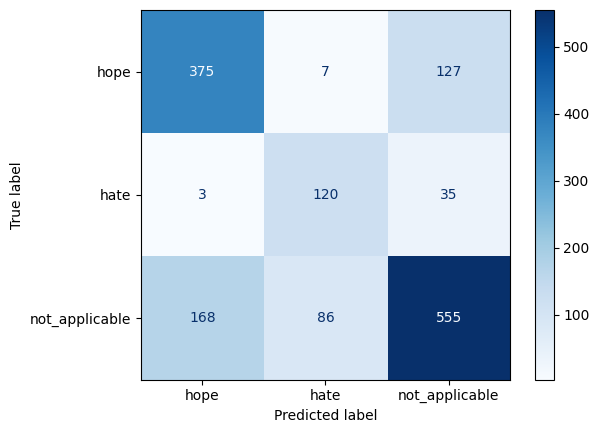

In [ ]:
import os, re, json, string, nltk
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import joblib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = "/content/drive/MyDrive/colab_data/new_for_research"
max_len = 128

emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U00002700-\U000027BF"  # dingbats
    "\U0001F900-\U0001F9FF"  # supplemental symbols
    "\U00002600-\U000026FF"  # miscellaneous symbols
    "\U00002B00-\U00002BFF"  # arrows
    "]+",
    flags=re.UNICODE
)

def remove_emojis(text):
    return emoji_pattern.sub(r'', text)

#  Same Cleaning Functions as Training
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    return re.sub(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]", "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda m: emoji_to_arabic.get(m.group(0), m.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def clean_text(text):
    text = str(text).strip()
    text = remove_emojis(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text

#  Dataset
class ArabicDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        texts = [clean_text(t) for t in texts]
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

#  Model (must match training)
class BertBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

#  Load Tokenizer & Models
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

model_hope_loaded = BertBinaryClassifier()
model_hope_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hope_classifier_meta_without_emoji.pt"), map_location=device))
model_hope_loaded.to(device).eval()

model_hate_loaded = BertBinaryClassifier()
model_hate_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hate_classifier_meta_without_emoji.pt"), map_location=device))
model_hate_loaded.to(device).eval()

meta_clf_loaded = joblib.load(os.path.join(save_dir, "meta_classifier_meta_without_emoji.pkl"))

#  Function to Get Model Probabilities
def get_model_probs(model, texts):
    dataset = ArabicDataset(texts, tokenizer, max_len)
    loader = DataLoader(dataset, batch_size=16)
    probs_all = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            outputs = model(input_ids, attn)
            probs = torch.softmax(outputs, dim=1)
            probs_all.extend(probs.cpu().numpy())
    return np.array(probs_all)

#  Load Validation Data
val_df = pd.read_csv("/content/drive/MyDrive/colab_data/files/validation_predictions.csv")
val_df["text"] = val_df["text"].astype(str)

label_map = {"hope": 0, "hate": 1, "not_applicable": 2}
labels_val = val_df["predicted_label"].map(label_map).astype(int).tolist()

#  Run Models
hope_logits_val = get_model_probs(model_hope_loaded, val_df["text"].tolist())
hate_logits_val = get_model_probs(model_hate_loaded, val_df["text"].tolist())

meta_features_val = np.concatenate([hope_logits_val, hate_logits_val], axis=1)
y_pred_meta = meta_clf_loaded.predict(meta_features_val)

#  Reports
print("\n📊 Hope Classifier Report:")
y_pred_hope = np.argmax(hope_logits_val, axis=1)
y_true_hope = [1 if l == 0 else 0 for l in labels_val]
print(classification_report(y_true_hope, y_pred_hope, target_names=["not_hope", "hope"]))
ConfusionMatrixDisplay(confusion_matrix(y_true_hope, y_pred_hope),
                       display_labels=["not_hope", "hope"]).plot(cmap=plt.cm.Blues)
plt.show()

print("\n📊 Hate Classifier Report:")
y_pred_hate = np.argmax(hate_logits_val, axis=1)
y_true_hate = [1 if l == 1 else 0 for l in labels_val]
print(classification_report(y_true_hate, y_pred_hate, target_names=["not_hate", "hate"]))
ConfusionMatrixDisplay(confusion_matrix(y_true_hate, y_pred_hate),
                       display_labels=["not_hate", "hate"]).plot(cmap=plt.cm.Blues)
plt.show()

print("\n📊 Meta Classifier Report (Final Prediction):")
print(classification_report(labels_val, y_pred_meta, target_names=["hope", "hate", "not_applicable"]))
ConfusionMatrixDisplay(confusion_matrix(labels_val, y_pred_meta),
                       display_labels=["hope", "hate", "not_applicable"]).plot(cmap=plt.cm.Blues)
plt.show()


# Meta classifier stack optimized models |  without emojis evaluation on test.csv


📊 Hope Classifier Report:
              precision    recall  f1-score   support

    not_hope       0.97      0.95      0.96      1055
        hope       0.88      0.94      0.91       422

    accuracy                           0.94      1477
   macro avg       0.93      0.94      0.93      1477
weighted avg       0.95      0.94      0.95      1477



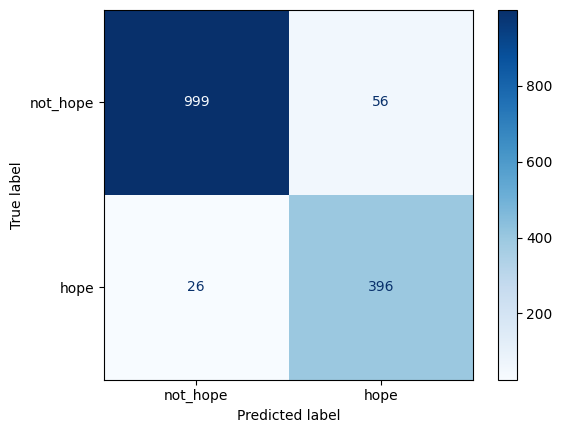


📊 Hate Classifier Report:
              precision    recall  f1-score   support

    not_hate       0.98      0.99      0.98      1190
        hate       0.94      0.90      0.92       287

    accuracy                           0.97      1477
   macro avg       0.96      0.94      0.95      1477
weighted avg       0.97      0.97      0.97      1477



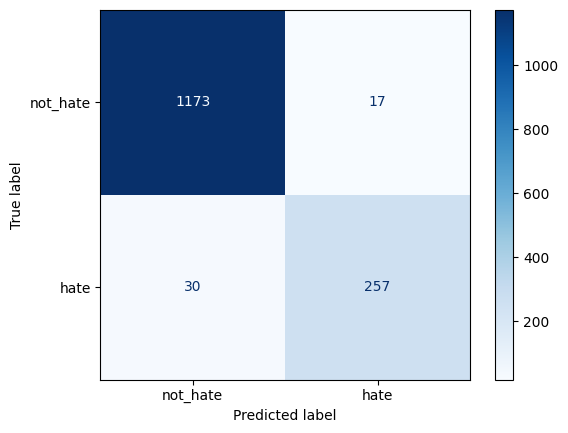


📊 Meta Classifier Report (Final Prediction):
                precision    recall  f1-score   support

          hope       0.88      0.93      0.91       422
          hate       0.94      0.90      0.92       287
not_applicable       0.92      0.91      0.92       768

      accuracy                           0.91      1477
     macro avg       0.92      0.91      0.91      1477
  weighted avg       0.91      0.91      0.91      1477



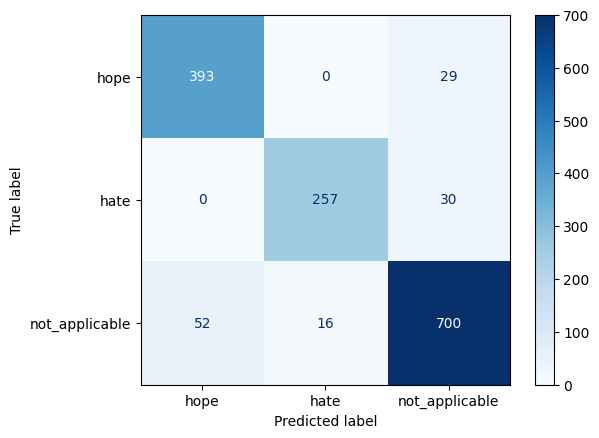

In [ ]:
import os, re, json, string, nltk
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import joblib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = "/content/drive/MyDrive/colab_data/new_for_research"
max_len = 128

emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U00002700-\U000027BF"  # dingbats
    "\U0001F900-\U0001F9FF"  # supplemental symbols
    "\U00002600-\U000026FF"  # miscellaneous symbols
    "\U00002B00-\U00002BFF"  # arrows
    "]+",
    flags=re.UNICODE
)

def remove_emojis(text):
    return emoji_pattern.sub(r'', text)

#  Same Cleaning Functions as Training
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    return re.sub(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]", "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda m: emoji_to_arabic.get(m.group(0), m.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def clean_text(text):
    text = str(text).strip()
    text = remove_emojis(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text

#  Dataset
class ArabicDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        texts = [clean_text(t) for t in texts]
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

#  Model (must match training)
class BertBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

#  Load Tokenizer & Models
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

model_hope_loaded = BertBinaryClassifier()
model_hope_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hope_classifier_meta_without_emoji.pt"), map_location=device))
model_hope_loaded.to(device).eval()

model_hate_loaded = BertBinaryClassifier()
model_hate_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hate_classifier_meta_without_emoji.pt"), map_location=device))
model_hate_loaded.to(device).eval()

meta_clf_loaded = joblib.load(os.path.join(save_dir, "meta_classifier_meta_without_emoji.pkl"))

#  Function to Get Model Probabilities
def get_model_probs(model, texts):
    dataset = ArabicDataset(texts, tokenizer, max_len)
    loader = DataLoader(dataset, batch_size=16)
    probs_all = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            outputs = model(input_ids, attn)
            probs = torch.softmax(outputs, dim=1)
            probs_all.extend(probs.cpu().numpy())
    return np.array(probs_all)

#  Load Validation Data
val_df = pd.read_csv("/content/drive/MyDrive/colab_data/files/test.csv")
val_df["text"] = val_df["text"].astype(str)

label_map = {"hope": 0, "hate": 1, "not_applicable": 2}
labels_val = val_df["label"].map(label_map).astype(int).tolist()

#  Run Models
hope_logits_val = get_model_probs(model_hope_loaded, val_df["text"].tolist())
hate_logits_val = get_model_probs(model_hate_loaded, val_df["text"].tolist())

meta_features_val = np.concatenate([hope_logits_val, hate_logits_val], axis=1)
y_pred_meta = meta_clf_loaded.predict(meta_features_val)

#  Reports
print("\n📊 Hope Classifier Report:")
y_pred_hope = np.argmax(hope_logits_val, axis=1)
y_true_hope = [1 if l == 0 else 0 for l in labels_val]
print(classification_report(y_true_hope, y_pred_hope, target_names=["not_hope", "hope"]))
ConfusionMatrixDisplay(confusion_matrix(y_true_hope, y_pred_hope),
                       display_labels=["not_hope", "hope"]).plot(cmap=plt.cm.Blues)
plt.show()

print("\n📊 Hate Classifier Report:")
y_pred_hate = np.argmax(hate_logits_val, axis=1)
y_true_hate = [1 if l == 1 else 0 for l in labels_val]
print(classification_report(y_true_hate, y_pred_hate, target_names=["not_hate", "hate"]))
ConfusionMatrixDisplay(confusion_matrix(y_true_hate, y_pred_hate),
                       display_labels=["not_hate", "hate"]).plot(cmap=plt.cm.Blues)
plt.show()

print("\n📊 Meta Classifier Report (Final Prediction):")
print(classification_report(labels_val, y_pred_meta, target_names=["hope", "hate", "not_applicable"]))
ConfusionMatrixDisplay(confusion_matrix(labels_val, y_pred_meta),
                       display_labels=["hope", "hate", "not_applicable"]).plot(cmap=plt.cm.Blues)
plt.show()


# Not applicable labels are splitted into 2 half, and first half used in hope classifier, second one used in hate classifier, and both used in meta classifier during training.



In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import json, re, nltk, numpy as np
nltk.download('stopwords')
from nltk.corpus import stopwords

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Load Data
df = pd.read_csv("/content/drive/MyDrive/colab_data/files/train.csv")

texts_raw = df["text"].astype(str).tolist()
labels = df["label"].map({"hope": 0, "hate": 1, "not_applicable": 2}).tolist()

#  Preprocessing
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))

def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda match: emoji_to_arabic.get(match.group(0), match.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def clean_text(text):
    text = text.strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text

# texts = [clean_text(t) for t in texts_raw]

#  Split not_applicable into two halves
df_not_app = df[df["label"] == "not_applicable"].reset_index(drop=True)
half = len(df_not_app) // 2
df_not_app_hope = df_not_app.iloc[:half]   # goes to hope classifier
df_not_app_hate = df_not_app.iloc[half:]   # goes to hate classifier

#  Build Hope classifier dataframe
df_hope = pd.concat([
    df[df["label"] == "hope"],        # positive
    df[df["label"] == "hate"],        # negative
    df_not_app_hope                   # negative
]).reset_index(drop=True)

texts_hope = [clean_text(t) for t in df_hope["text"].astype(str).tolist()]
labels_hope = [1 if y == "hope" else 0 for y in df_hope["label"].tolist()]

#  Build Hate classifier dataframe
df_hate = pd.concat([
    df[df["label"] == "hate"],        # positive
    df[df["label"] == "hope"],        # negative
    df_not_app_hate                   # negative
]).reset_index(drop=True)

texts_hate = [clean_text(t) for t in df_hate["text"].astype(str).tolist()]
labels_hate = [1 if y == "hate" else 0 for y in df_hate["label"].tolist()]

#  Dataset
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

class ArabicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

#  Model
class BertBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

#  Training Function
def train_binary_model(texts, binary_labels, label_name=""):
    X_train, X_val, y_train, y_val = train_test_split(
        texts, binary_labels, test_size=0.2, stratify=binary_labels, random_state=42
    )

    train_ds = ArabicDataset(X_train, y_train, tokenizer)
    val_ds = ArabicDataset(X_val, y_val, tokenizer)
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=16)

    model = BertBinaryClassifier().to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    # Train loop
    for epoch in range(8):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attn = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attn)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # epoch summary
        print(f"[{label_name}] Epoch {epoch+1}/{8} "
              f"| Avg Loss: {total_loss/len(train_loader):.4f} "
              f"| Accuracy: {correct/total:.4f}")
        print(f"[{label_name}] Epoch {epoch+1} | Loss: {total_loss:.4f} | Acc: {correct/total:.4f}")

    # Validation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attn = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attn)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(f"\n📊 {label_name} Classification Report")
    print(classification_report(all_labels, all_preds, digits=3))
    return model

#  Train hope vs not_applicable
print("Training Hope Classifier...")
model_hope = train_binary_model(texts_hope, labels_hope, label_name="Hope")

#  Train hate vs not_applicable
print("Training Hate Classifier...")
model_hate = train_binary_model(texts_hate, labels_hate, label_name="Hate")

#  Get Model Probabilities
def get_model_probs(model, texts):
    dataset = ArabicDataset(texts, [0]*len(texts), tokenizer)
    loader = DataLoader(dataset, batch_size=16)
    model.eval()
    probs_all = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            outputs = model(input_ids, attn)
            probs = torch.softmax(outputs, dim=1)
            probs_all.extend(probs.cpu().numpy())
    return np.array(probs_all)

# Get both models' outputs on the same dataset (all texts)
texts_all = [clean_text(t) for t in texts_raw]

hope_logits = get_model_probs(model_hope, texts_all)
hate_logits = get_model_probs(model_hate, texts_all)

# Concatenate to form meta features
meta_features = np.concatenate([hope_logits, hate_logits], axis=1)

#  Meta Classifier
print("Training Meta Classifier...")
X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(
    meta_features, labels, test_size=0.2, stratify=labels, random_state=42
)

meta_clf = LogisticRegression(max_iter=200)
meta_clf.fit(X_train_meta, y_train_meta)

y_pred_meta = meta_clf.predict(X_val_meta)
print("\nMeta Classifier Performance:")
print(classification_report(y_val_meta, y_pred_meta, target_names=["hope", "hate", "not_applicable"], digits=3))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training Hope Classifier...
[Hope] Epoch 1/8 | Avg Loss: 0.5122 | Accuracy: 0.7349
[Hope] Epoch 1 | Loss: 129.0751 | Acc: 0.7349
[Hope] Epoch 2/8 | Avg Loss: 0.3841 | Accuracy: 0.8172
[Hope] Epoch 2 | Loss: 96.7966 | Acc: 0.8172
[Hope] Epoch 3/8 | Avg Loss: 0.2522 | Accuracy: 0.8906
[Hope] Epoch 3 | Loss: 63.5470 | Acc: 0.8906
[Hope] Epoch 4/8 | Avg Loss: 0.1659 | Accuracy: 0.9370
[Hope] Epoch 4 | Loss: 41.8088 | Acc: 0.9370
[Hope] Epoch 5/8 | Avg Loss: 0.0752 | Accuracy: 0.9727
[Hope] Epoch 5 | Loss: 18.9537 | Acc: 0.9727
[Hope] Epoch 6/8 | Avg Loss: 0.0498 | Accuracy: 0.9809
[Hope] Epoch 6 | Loss: 12.5511 | Acc: 0.9809
[Hope] Epoch 7/8 | Avg Loss: 0.0360 | Accuracy: 0.9856
[Hope] Epoch 7 | Loss: 9.0800 | Acc: 0.9856
[Hope] Epoch 8/8 | Avg Loss: 0.0455 | Accuracy: 0.9856
[Hope] Epoch 8 | Loss: 11.4674 | Acc: 0.9856

📊 Hope Classification Report
              precision    recall  f1-score   support

           0      0.851     0.724     0.782       630
           1      0.632     0.789

NameError: name 'texts' is not defined

In [ ]:

# Get both models' outputs on the same dataset (all texts)
texts_all = [clean_text(t) for t in texts_raw]

hope_logits = get_model_probs(model_hope, texts_all)
hate_logits = get_model_probs(model_hate, texts_all)

# Concatenate to form meta features
meta_features = np.concatenate([hope_logits, hate_logits], axis=1)

#  Meta Classifier
print("Training Meta Classifier...")
X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(
    meta_features, labels, test_size=0.2, stratify=labels, random_state=42
)

meta_clf = LogisticRegression(max_iter=200)
meta_clf.fit(X_train_meta, y_train_meta)

y_pred_meta = meta_clf.predict(X_val_meta)
print("\nMeta Classifier Performance:")
print(classification_report(y_val_meta, y_pred_meta, target_names=["hope", "hate", "not_applicable"], digits=3))

Training Meta Classifier...

Meta Classifier Performance:
                precision    recall  f1-score   support

          hope      0.696     0.918     0.792       379
          hate      0.721     0.915     0.807       260
not_applicable      0.920     0.682     0.783       739

      accuracy                          0.791      1378
     macro avg      0.779     0.839     0.794      1378
  weighted avg      0.821     0.791     0.790      1378



In [ ]:
import os

save_dir = "/content/drive/MyDrive/colab_data/new_for_research"
os.makedirs(save_dir, exist_ok=True)


# Save BERT-based binary classifiers
torch.save(model_hope.state_dict(), os.path.join(save_dir, "hope_classifier_na_balanced.pt"))
torch.save(model_hate.state_dict(), os.path.join(save_dir, "hate_classifier_na_balanced.pt"))


import joblib

joblib.dump(meta_clf, os.path.join(save_dir, "meta_classifier_na_balanced.pkl"))


['/content/drive/MyDrive/colab_data/new_for_research/meta_classifier_na_balanced.pkl']

# Not applicable splitted model evaluation on Validation.csv


📊 Hope Classifier Report:
              precision    recall  f1-score   support

    not_hope       0.95      0.78      0.86       967
        hope       0.69      0.92      0.79       509

    accuracy                           0.83      1476
   macro avg       0.82      0.85      0.82      1476
weighted avg       0.86      0.83      0.83      1476



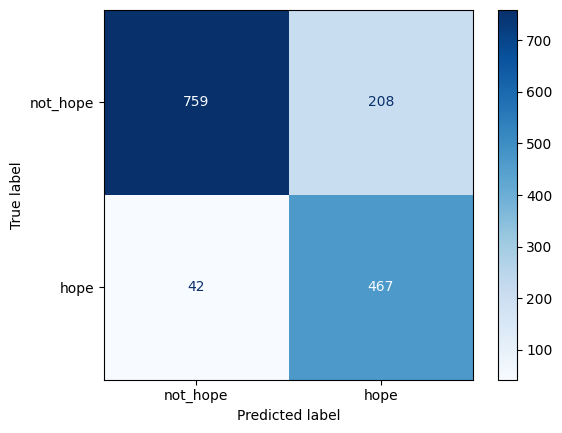


📊 Hate Classifier Report:
              precision    recall  f1-score   support

    not_hate       0.99      0.83      0.91      1318
        hate       0.41      0.96      0.58       158

    accuracy                           0.85      1476
   macro avg       0.70      0.90      0.74      1476
weighted avg       0.93      0.85      0.87      1476



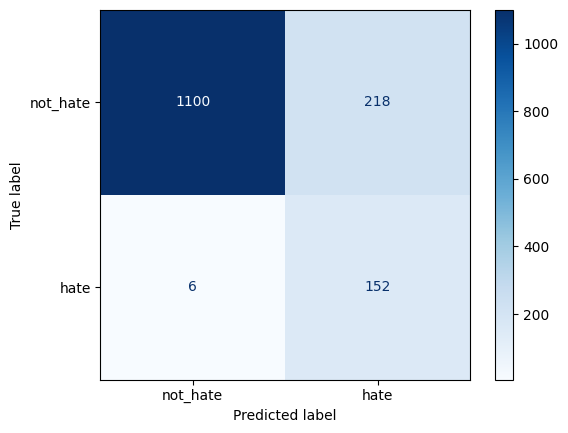


📊 Meta Classifier Report (Final Prediction):
                precision    recall  f1-score   support

          hope       0.75      0.87      0.81       509
          hate       0.46      0.92      0.61       158
not_applicable       0.89      0.62      0.73       809

      accuracy                           0.74      1476
     macro avg       0.70      0.80      0.72      1476
  weighted avg       0.79      0.74      0.74      1476



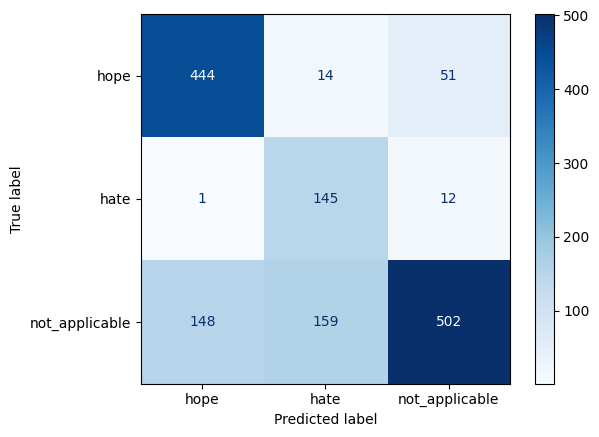

In [ ]:
import os, re, json, string, nltk
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import joblib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = "/content/drive/MyDrive/colab_data/new_for_research"
max_len = 128

#  Load Emoji Map
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))

#  Same Cleaning Functions as Training
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    return re.sub(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]", "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda m: emoji_to_arabic.get(m.group(0), m.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def clean_text(text):
    text = str(text).strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text

#  Dataset
class ArabicDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        texts = [clean_text(t) for t in texts]
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

#  Model (must match training)
class BertBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

#  Load Tokenizer & Models
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

model_hope_loaded = BertBinaryClassifier()
model_hope_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hope_classifier_na_balanced.pt"), map_location=device))
model_hope_loaded.to(device).eval()

model_hate_loaded = BertBinaryClassifier()
model_hate_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hate_classifier_na_balanced.pt"), map_location=device))
model_hate_loaded.to(device).eval()

meta_clf_loaded = joblib.load(os.path.join(save_dir, "meta_classifier_na_balanced.pkl"))

#  Function to Get Model Probabilities
def get_model_probs(model, texts):
    dataset = ArabicDataset(texts, tokenizer, max_len)
    loader = DataLoader(dataset, batch_size=16)
    probs_all = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            outputs = model(input_ids, attn)
            probs = torch.softmax(outputs, dim=1)
            probs_all.extend(probs.cpu().numpy())
    return np.array(probs_all)

#  Load Validation Data
val_df = pd.read_csv("/content/drive/MyDrive/colab_data/files/validation_predictions.csv")
val_df["text"] = val_df["text"].astype(str)

label_map = {"hope": 0, "hate": 1, "not_applicable": 2}
labels_val = val_df["predicted_label"].map(label_map).astype(int).tolist()

#  Run Models
hope_logits_val = get_model_probs(model_hope_loaded, val_df["text"].tolist())
hate_logits_val = get_model_probs(model_hate_loaded, val_df["text"].tolist())

meta_features_val = np.concatenate([hope_logits_val, hate_logits_val], axis=1)
y_pred_meta = meta_clf_loaded.predict(meta_features_val)

#  Reports
print("\n📊 Hope Classifier Report:")
y_pred_hope = np.argmax(hope_logits_val, axis=1)
y_true_hope = [1 if l == 0 else 0 for l in labels_val]
print(classification_report(y_true_hope, y_pred_hope, target_names=["not_hope", "hope"]))
ConfusionMatrixDisplay(confusion_matrix(y_true_hope, y_pred_hope),
                       display_labels=["not_hope", "hope"]).plot(cmap=plt.cm.Blues)
plt.show()

print("\n📊 Hate Classifier Report:")
y_pred_hate = np.argmax(hate_logits_val, axis=1)
y_true_hate = [1 if l == 1 else 0 for l in labels_val]
print(classification_report(y_true_hate, y_pred_hate, target_names=["not_hate", "hate"]))
ConfusionMatrixDisplay(confusion_matrix(y_true_hate, y_pred_hate),
                       display_labels=["not_hate", "hate"]).plot(cmap=plt.cm.Blues)
plt.show()

print("\n📊 Meta Classifier Report (Final Prediction):")
print(classification_report(labels_val, y_pred_meta, target_names=["hope", "hate", "not_applicable"]))
ConfusionMatrixDisplay(confusion_matrix(labels_val, y_pred_meta),
                       display_labels=["hope", "hate", "not_applicable"]).plot(cmap=plt.cm.Blues)
plt.show()


# Not applicable splitted model evaluation on test.csv


📊 Hope Classifier Report:
              precision    recall  f1-score   support

    not_hope       0.91      0.68      0.78      1055
        hope       0.51      0.84      0.64       422

    accuracy                           0.73      1477
   macro avg       0.71      0.76      0.71      1477
weighted avg       0.80      0.73      0.74      1477



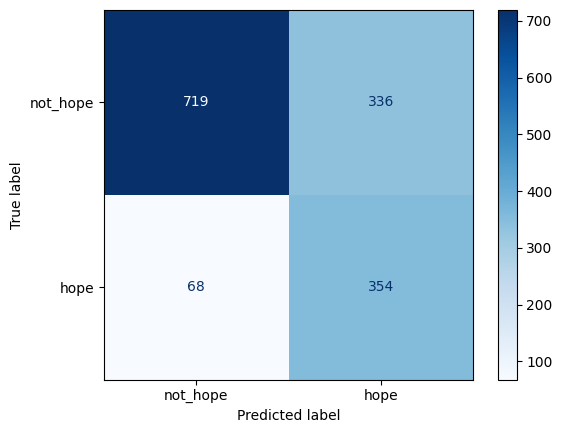


📊 Hate Classifier Report:
              precision    recall  f1-score   support

    not_hate       0.94      0.85      0.90      1190
        hate       0.57      0.79      0.66       287

    accuracy                           0.84      1477
   macro avg       0.76      0.82      0.78      1477
weighted avg       0.87      0.84      0.85      1477



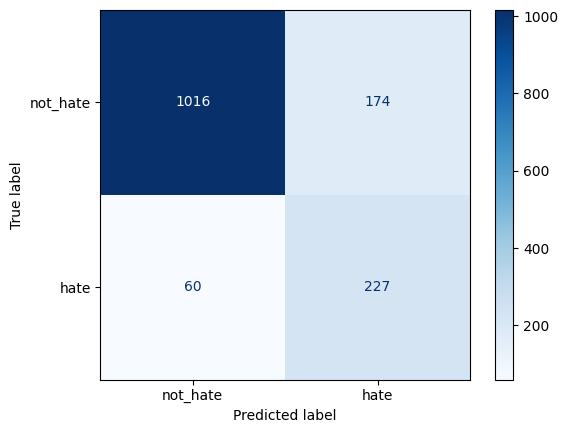


📊 Meta Classifier Report (Final Prediction):
                precision    recall  f1-score   support

          hope       0.54      0.80      0.64       422
          hate       0.60      0.73      0.66       287
not_applicable       0.74      0.49      0.59       768

      accuracy                           0.62      1477
     macro avg       0.62      0.67      0.63      1477
  weighted avg       0.65      0.62      0.62      1477



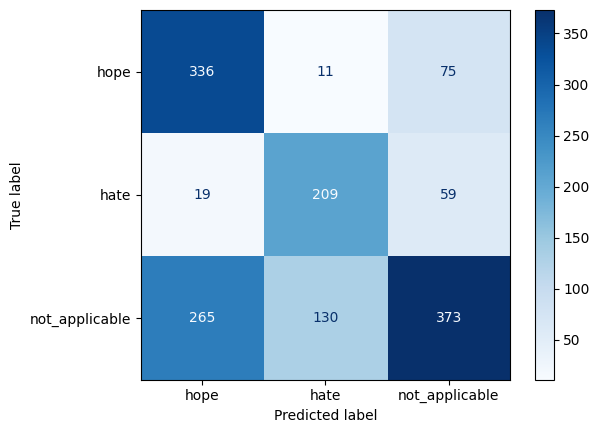

In [ ]:
import os, re, json, string, nltk
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import joblib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = "/content/drive/MyDrive/colab_data/new_for_research"
max_len = 128

#  Load Emoji Map
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))

#  Same Cleaning Functions as Training
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    return re.sub(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]", "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda m: emoji_to_arabic.get(m.group(0), m.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def clean_text(text):
    text = str(text).strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text

#  Dataset
class ArabicDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        texts = [clean_text(t) for t in texts]
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

#  Model (must match training)
class BertBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

#  Load Tokenizer & Models
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

model_hope_loaded = BertBinaryClassifier()
model_hope_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hope_classifier_na_balanced.pt"), map_location=device))
model_hope_loaded.to(device).eval()

model_hate_loaded = BertBinaryClassifier()
model_hate_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hate_classifier_na_balanced.pt"), map_location=device))
model_hate_loaded.to(device).eval()

meta_clf_loaded = joblib.load(os.path.join(save_dir, "meta_classifier_na_balanced.pkl"))

#  Function to Get Model Probabilities
def get_model_probs(model, texts):
    dataset = ArabicDataset(texts, tokenizer, max_len)
    loader = DataLoader(dataset, batch_size=16)
    probs_all = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            outputs = model(input_ids, attn)
            probs = torch.softmax(outputs, dim=1)
            probs_all.extend(probs.cpu().numpy())
    return np.array(probs_all)

#  Load Validation Data
val_df = pd.read_csv("/content/drive/MyDrive/colab_data/files/test.csv")
val_df["text"] = val_df["text"].astype(str)

label_map = {"hope": 0, "hate": 1, "not_applicable": 2}
labels_val = val_df["label"].map(label_map).astype(int).tolist()

#  Run Models
hope_logits_val = get_model_probs(model_hope_loaded, val_df["text"].tolist())
hate_logits_val = get_model_probs(model_hate_loaded, val_df["text"].tolist())

meta_features_val = np.concatenate([hope_logits_val, hate_logits_val], axis=1)
y_pred_meta = meta_clf_loaded.predict(meta_features_val)

#  Reports
print("\n📊 Hope Classifier Report:")
y_pred_hope = np.argmax(hope_logits_val, axis=1)
y_true_hope = [1 if l == 0 else 0 for l in labels_val]
print(classification_report(y_true_hope, y_pred_hope, target_names=["not_hope", "hope"]))
ConfusionMatrixDisplay(confusion_matrix(y_true_hope, y_pred_hope),
                       display_labels=["not_hope", "hope"]).plot(cmap=plt.cm.Blues)
plt.show()

print("\n📊 Hate Classifier Report:")
y_pred_hate = np.argmax(hate_logits_val, axis=1)
y_true_hate = [1 if l == 1 else 0 for l in labels_val]
print(classification_report(y_true_hate, y_pred_hate, target_names=["not_hate", "hate"]))
ConfusionMatrixDisplay(confusion_matrix(y_true_hate, y_pred_hate),
                       display_labels=["not_hate", "hate"]).plot(cmap=plt.cm.Blues)
plt.show()

print("\n📊 Meta Classifier Report (Final Prediction):")
print(classification_report(labels_val, y_pred_meta, target_names=["hope", "hate", "not_applicable"]))
ConfusionMatrixDisplay(confusion_matrix(labels_val, y_pred_meta),
                       display_labels=["hope", "hate", "not_applicable"]).plot(cmap=plt.cm.Blues)
plt.show()

# Not applicable splitted model without emojis

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import json, re, nltk, numpy as np
nltk.download('stopwords')
from nltk.corpus import stopwords

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Load Data
df = pd.read_csv("/content/drive/MyDrive/colab_data/files/train.csv")

texts_raw = df["text"].astype(str).tolist()
labels = df["label"].map({"hope": 0, "hate": 1, "not_applicable": 2}).tolist()


def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U00002700-\U000027BF"  # dingbats
    "\U0001F900-\U0001F9FF"  # supplemental symbols
    "\U00002600-\U000026FF"  # miscellaneous symbols
    "\U00002B00-\U00002BFF"  # arrows
    "]+",
    flags=re.UNICODE
)

def remove_emojis(text):
    return emoji_pattern.sub(r'', text)



def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def clean_text(text):
    text = text.strip()
    text = remove_emojis(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text

# texts = [clean_text(t) for t in texts_raw]

#  Split not_applicable into two halves
df_not_app = df[df["label"] == "not_applicable"].reset_index(drop=True)
half = len(df_not_app) // 2
df_not_app_hope = df_not_app.iloc[:half]   # goes to hope classifier
df_not_app_hate = df_not_app.iloc[half:]   # goes to hate classifier

#  Build Hope classifier dataframe
df_hope = pd.concat([
    df[df["label"] == "hope"],        # positive
    df[df["label"] == "hate"],        # negative
    df_not_app_hope                   # negative
]).reset_index(drop=True)

texts_hope = [clean_text(t) for t in df_hope["text"].astype(str).tolist()]
labels_hope = [1 if y == "hope" else 0 for y in df_hope["label"].tolist()]

#  Build Hate classifier dataframe
df_hate = pd.concat([
    df[df["label"] == "hate"],        # positive
    df[df["label"] == "hope"],        # negative
    df_not_app_hate                   # negative
]).reset_index(drop=True)

texts_hate = [clean_text(t) for t in df_hate["text"].astype(str).tolist()]
labels_hate = [1 if y == "hate" else 0 for y in df_hate["label"].tolist()]


# Binary label split
# labels_hope = [1 if y == 0 else 0 for y in labels]  # hope vs others
# labels_hate = [1 if y == 1 else 0 for y in labels]  # hate vs others

#  Dataset
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

class ArabicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

#  Model
class BertBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

#  Training Function
def train_binary_model(texts, binary_labels, label_name=""):
    X_train, X_val, y_train, y_val = train_test_split(
        texts, binary_labels, test_size=0.2, stratify=binary_labels, random_state=42
    )

    train_ds = ArabicDataset(X_train, y_train, tokenizer)
    val_ds = ArabicDataset(X_val, y_val, tokenizer)
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=16)

    model = BertBinaryClassifier().to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    # Train loop
    for epoch in range(8):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attn = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attn)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # epoch summary
        print(f"[{label_name}] Epoch {epoch+1}/{8} "
              f"| Avg Loss: {total_loss/len(train_loader):.4f} "
              f"| Accuracy: {correct/total:.4f}")
        print(f"[{label_name}] Epoch {epoch+1} | Loss: {total_loss:.4f} | Acc: {correct/total:.4f}")

    # Validation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attn = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attn)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(f"\n📊 {label_name} Classification Report")
    print(classification_report(all_labels, all_preds, digits=3))
    return model

#  Train hope vs not_applicable
print("Training Hope Classifier...")
model_hope = train_binary_model(texts_hope, labels_hope, label_name="Hope")

#  Train hate vs not_applicable
print("Training Hate Classifier...")
model_hate = train_binary_model(texts_hate, labels_hate, label_name="Hate")

#  Get Model Probabilities
def get_model_probs(model, texts):
    dataset = ArabicDataset(texts, [0]*len(texts), tokenizer)
    loader = DataLoader(dataset, batch_size=16)
    model.eval()
    probs_all = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            outputs = model(input_ids, attn)
            probs = torch.softmax(outputs, dim=1)
            probs_all.extend(probs.cpu().numpy())
    return np.array(probs_all)

# Get both models' outputs on the same dataset (all texts)
texts_all = [clean_text(t) for t in texts_raw]

hope_logits = get_model_probs(model_hope, texts_all)
hate_logits = get_model_probs(model_hate, texts_all)

# Concatenate to form meta features
meta_features = np.concatenate([hope_logits, hate_logits], axis=1)

#  Meta Classifier
print("Training Meta Classifier...")
X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(
    meta_features, labels, test_size=0.2, stratify=labels, random_state=42
)

meta_clf = LogisticRegression(max_iter=200)
meta_clf.fit(X_train_meta, y_train_meta)

y_pred_meta = meta_clf.predict(X_val_meta)
print("\nMeta Classifier Performance:")
print(classification_report(y_val_meta, y_pred_meta, target_names=["hope", "hate", "not_applicable"], digits=3))

KeyboardInterrupt: 

In [ ]:
import os

save_dir = "/content/drive/MyDrive/colab_data/new_for_research"
os.makedirs(save_dir, exist_ok=True)


# Save BERT-based binary classifiers
torch.save(model_hope.state_dict(), os.path.join(save_dir, "hope_classifier_na_balanced_without_emoji.pt"))
torch.save(model_hate.state_dict(), os.path.join(save_dir, "hate_classifier_na_balanced_without_emoji.pt"))


import joblib

joblib.dump(meta_clf, os.path.join(save_dir, "meta_classifier_na_balanced_without_emoji.pkl"))


['/content/drive/MyDrive/colab_data/new_for_research/meta_classifier_na_balanced_without_emoji.pkl']

# Not applicable splitted model Without emojis evaluation on validation.csv



📊 Hope Classifier Report:
              precision    recall  f1-score   support

    not_hope       0.86      0.92      0.89       967
        hope       0.82      0.72      0.76       509

    accuracy                           0.85      1476
   macro avg       0.84      0.82      0.83      1476
weighted avg       0.85      0.85      0.84      1476



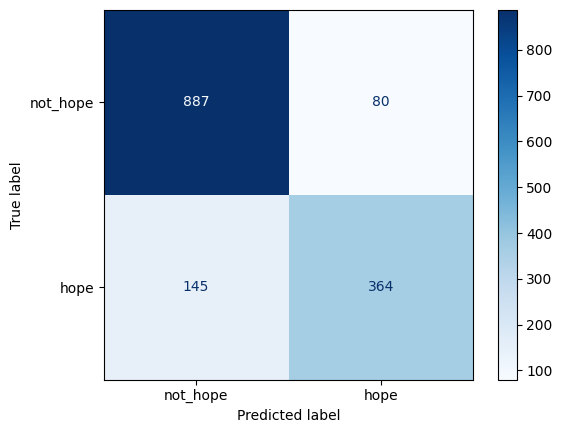


📊 Hate Classifier Report:
              precision    recall  f1-score   support

    not_hate       0.98      0.88      0.93      1318
        hate       0.46      0.87      0.60       158

    accuracy                           0.88      1476
   macro avg       0.72      0.87      0.77      1476
weighted avg       0.93      0.88      0.89      1476



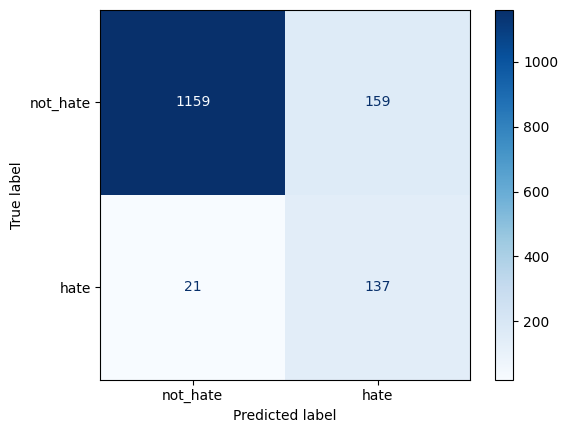


📊 Meta Classifier Report (Final Prediction):
                precision    recall  f1-score   support

          hope       0.85      0.65      0.74       509
          hate       0.49      0.85      0.63       158
not_applicable       0.77      0.77      0.77       809

      accuracy                           0.74      1476
     macro avg       0.71      0.76      0.71      1476
  weighted avg       0.77      0.74      0.74      1476



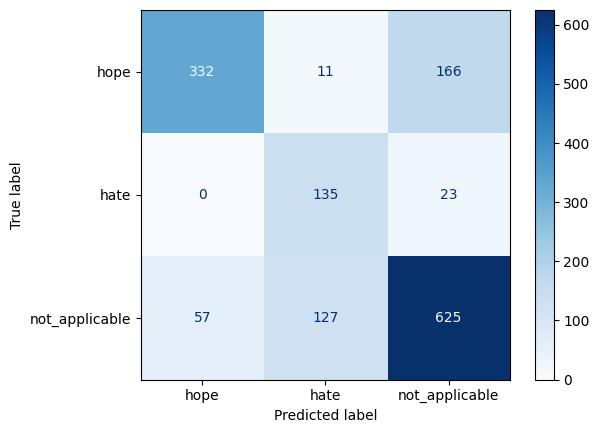

In [ ]:
import os, re, json, string, nltk
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import joblib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = "/content/drive/MyDrive/colab_data/new_for_research"
max_len = 128

#  Load Emoji Map
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U00002700-\U000027BF"  # dingbats
    "\U0001F900-\U0001F9FF"  # supplemental symbols
    "\U00002600-\U000026FF"  # miscellaneous symbols
    "\U00002B00-\U00002BFF"  # arrows
    "]+",
    flags=re.UNICODE
)

#  Same Cleaning Functions as Training
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    return re.sub(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]", "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)


def remove_emojis(text):
    return emoji_pattern.sub(r'', text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def clean_text(text):
    text = str(text).strip()
    text = remove_emojis(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text

#  Dataset
class ArabicDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        texts = [clean_text(t) for t in texts]
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

#  Model (must match training)
class BertBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

#  Load Tokenizer & Models
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

model_hope_loaded = BertBinaryClassifier()
model_hope_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hope_classifier_na_balanced_without_emoji.pt"), map_location=device))
model_hope_loaded.to(device).eval()

model_hate_loaded = BertBinaryClassifier()
model_hate_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hate_classifier_na_balanced_without_emoji.pt"), map_location=device))
model_hate_loaded.to(device).eval()

meta_clf_loaded = joblib.load(os.path.join(save_dir, "meta_classifier_na_balanced_without_emoji.pkl"))

#  Function to Get Model Probabilities
def get_model_probs(model, texts):
    dataset = ArabicDataset(texts, tokenizer, max_len)
    loader = DataLoader(dataset, batch_size=16)
    probs_all = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            outputs = model(input_ids, attn)
            probs = torch.softmax(outputs, dim=1)
            probs_all.extend(probs.cpu().numpy())
    return np.array(probs_all)

#  Load Validation Data
val_df = pd.read_csv("/content/drive/MyDrive/colab_data/files/validation_predictions.csv")
val_df["text"] = val_df["text"].astype(str)

label_map = {"hope": 0, "hate": 1, "not_applicable": 2}
labels_val = val_df["predicted_label"].map(label_map).astype(int).tolist()

#  Run Models
hope_logits_val = get_model_probs(model_hope_loaded, val_df["text"].tolist())
hate_logits_val = get_model_probs(model_hate_loaded, val_df["text"].tolist())

meta_features_val = np.concatenate([hope_logits_val, hate_logits_val], axis=1)
y_pred_meta = meta_clf_loaded.predict(meta_features_val)

#  Reports
print("\n📊 Hope Classifier Report:")
y_pred_hope = np.argmax(hope_logits_val, axis=1)
y_true_hope = [1 if l == 0 else 0 for l in labels_val]
print(classification_report(y_true_hope, y_pred_hope, target_names=["not_hope", "hope"]))
ConfusionMatrixDisplay(confusion_matrix(y_true_hope, y_pred_hope),
                       display_labels=["not_hope", "hope"]).plot(cmap=plt.cm.Blues)
plt.show()

print("\n📊 Hate Classifier Report:")
y_pred_hate = np.argmax(hate_logits_val, axis=1)
y_true_hate = [1 if l == 1 else 0 for l in labels_val]
print(classification_report(y_true_hate, y_pred_hate, target_names=["not_hate", "hate"]))
ConfusionMatrixDisplay(confusion_matrix(y_true_hate, y_pred_hate),
                       display_labels=["not_hate", "hate"]).plot(cmap=plt.cm.Blues)
plt.show()

print("\n📊 Meta Classifier Report (Final Prediction):")
print(classification_report(labels_val, y_pred_meta, target_names=["hope", "hate", "not_applicable"]))
ConfusionMatrixDisplay(confusion_matrix(labels_val, y_pred_meta),
                       display_labels=["hope", "hate", "not_applicable"]).plot(cmap=plt.cm.Blues)
plt.show()


# Not applicable splitted model Without emojis evaluation on test.csv


📊 Hope Classifier Report:
              precision    recall  f1-score   support

    not_hope       0.85      0.83      0.84      1055
        hope       0.60      0.63      0.61       422

    accuracy                           0.77      1477
   macro avg       0.72      0.73      0.73      1477
weighted avg       0.78      0.77      0.78      1477



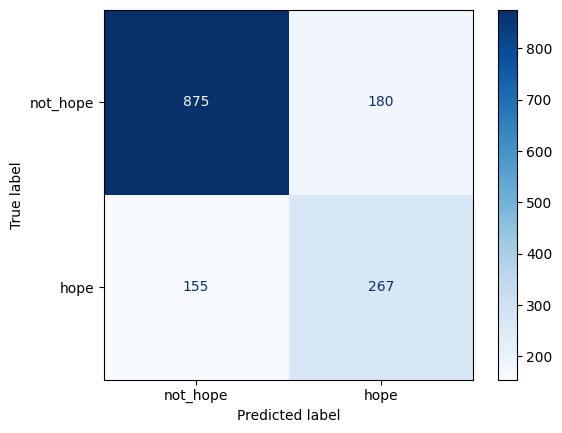


📊 Hate Classifier Report:
              precision    recall  f1-score   support

    not_hate       0.92      0.88      0.90      1190
        hate       0.57      0.66      0.61       287

    accuracy                           0.84      1477
   macro avg       0.74      0.77      0.76      1477
weighted avg       0.85      0.84      0.84      1477



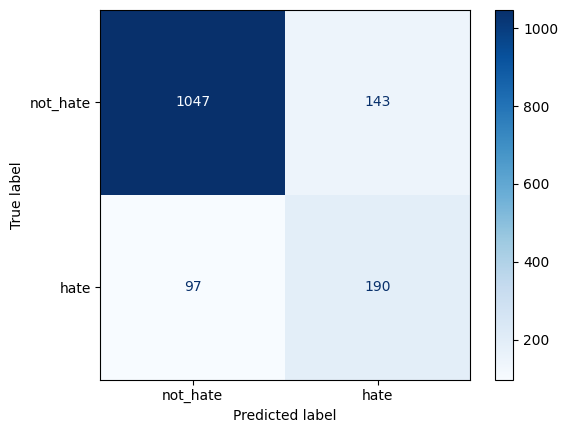


📊 Meta Classifier Report (Final Prediction):
                precision    recall  f1-score   support

          hope       0.61      0.58      0.60       422
          hate       0.61      0.63      0.62       287
not_applicable       0.66      0.66      0.66       768

      accuracy                           0.63      1477
     macro avg       0.62      0.62      0.62      1477
  weighted avg       0.63      0.63      0.63      1477



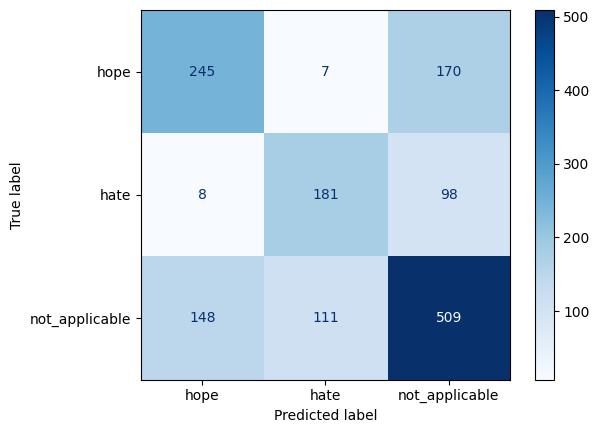

In [ ]:
import os, re, json, string, nltk
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import joblib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = "/content/drive/MyDrive/colab_data/new_for_research"
max_len = 128

#  Load Emoji Map
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U00002700-\U000027BF"  # dingbats
    "\U0001F900-\U0001F9FF"  # supplemental symbols
    "\U00002600-\U000026FF"  # miscellaneous symbols
    "\U00002B00-\U00002BFF"  # arrows
    "]+",
    flags=re.UNICODE
)

#  Same Cleaning Functions as Training
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    return re.sub(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]", "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def remove_emojis(text):
    return emoji_pattern.sub(r'', text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def clean_text(text):
    text = str(text).strip()
    text = remove_emojis(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text

#  Dataset
class ArabicDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        texts = [clean_text(t) for t in texts]
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

#  Model (must match training)
class BertBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

#  Load Tokenizer & Models
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

model_hope_loaded = BertBinaryClassifier()
model_hope_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hope_classifier_na_balanced_without_emoji.pt"), map_location=device))
model_hope_loaded.to(device).eval()

model_hate_loaded = BertBinaryClassifier()
model_hate_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hate_classifier_na_balanced_without_emoji.pt"), map_location=device))
model_hate_loaded.to(device).eval()

meta_clf_loaded = joblib.load(os.path.join(save_dir, "meta_classifier_na_balanced_without_emoji.pkl"))

#  Function to Get Model Probabilities
def get_model_probs(model, texts):
    dataset = ArabicDataset(texts, tokenizer, max_len)
    loader = DataLoader(dataset, batch_size=16)
    probs_all = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            outputs = model(input_ids, attn)
            probs = torch.softmax(outputs, dim=1)
            probs_all.extend(probs.cpu().numpy())
    return np.array(probs_all)

#  Load Validation Data
val_df = pd.read_csv("/content/drive/MyDrive/colab_data/files/test.csv")
val_df["text"] = val_df["text"].astype(str)

label_map = {"hope": 0, "hate": 1, "not_applicable": 2}
labels_val = val_df["label"].map(label_map).astype(int).tolist()

#  Run Models
hope_logits_val = get_model_probs(model_hope_loaded, val_df["text"].tolist())
hate_logits_val = get_model_probs(model_hate_loaded, val_df["text"].tolist())

meta_features_val = np.concatenate([hope_logits_val, hate_logits_val], axis=1)
y_pred_meta = meta_clf_loaded.predict(meta_features_val)

#  Reports
print("\n📊 Hope Classifier Report:")
y_pred_hope = np.argmax(hope_logits_val, axis=1)
y_true_hope = [1 if l == 0 else 0 for l in labels_val]
print(classification_report(y_true_hope, y_pred_hope, target_names=["not_hope", "hope"]))
ConfusionMatrixDisplay(confusion_matrix(y_true_hope, y_pred_hope),
                       display_labels=["not_hope", "hope"]).plot(cmap=plt.cm.Blues)
plt.show()

print("\n📊 Hate Classifier Report:")
y_pred_hate = np.argmax(hate_logits_val, axis=1)
y_true_hate = [1 if l == 1 else 0 for l in labels_val]
print(classification_report(y_true_hate, y_pred_hate, target_names=["not_hate", "hate"]))
ConfusionMatrixDisplay(confusion_matrix(y_true_hate, y_pred_hate),
                       display_labels=["not_hate", "hate"]).plot(cmap=plt.cm.Blues)
plt.show()

print("\n📊 Meta Classifier Report (Final Prediction):")
print(classification_report(labels_val, y_pred_meta, target_names=["hope", "hate", "not_applicable"]))
ConfusionMatrixDisplay(confusion_matrix(labels_val, y_pred_meta),
                       display_labels=["hope", "hate", "not_applicable"]).plot(cmap=plt.cm.Blues)
plt.show()

# Old code using oversampling method

In [ ]:
# Oversampling

from imblearn.over_sampling import RandomOverSampler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from torch.optim import AdamW
import numpy as np

#  Inputs
# text = list of tokenized lists
# labels = list of integers (0=hope, 1=hate, 2=not_applicable)

# Step 1: Preprocess text
texts = [' '.join(words) for words in text]

# Binary label split
labels_hope = [1 if y == 0 else 0 for y in labels]  # hope vs not_applicable
labels_hate = [1 if y == 1 else 0 for y in labels]  # hate vs not_applicable

#  Dataset Class
class ArabicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

#  Model
class ArabicBinaryClassifier(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.bert = base_model
        self.fc = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = output.last_hidden_state[:, 0, :]
        return self.fc(cls_output)

#  Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")

#  Helper Function
def train_binary_model(texts, binary_labels):
    # Split into train and validation first (to avoid leakage)
    X_train, X_val, y_train, y_val = train_test_split(
        texts, binary_labels, test_size=0.2, stratify=binary_labels, random_state=42
    )

    # Oversample the training data to fix imbalance
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), y_train)
    X_train = X_train.flatten().tolist()  # back to list of strings

    # Compute weights AFTER oversampling (optional — could be 1:1 now)
    weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = torch.tensor(weights, dtype=torch.float).to(device)

    # Dataset
    train_ds = ArabicDataset(X_train, y_train, tokenizer)
    val_ds = ArabicDataset(X_val, y_val, tokenizer)
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=16)

    # Create a fresh BERT model for each classifier
    bert_model = AutoModel.from_pretrained("asafaya/bert-base-arabic")

    # Model
    model = ArabicBinaryClassifier(bert_model).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Train
    for epoch in range(8):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attn = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attn)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Eval
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attn = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attn)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds))
    return model



#  Train hope vs not_applicable
print("Training Hope Classifier...")
model_hope = train_binary_model(texts, labels_hope)

#  Train hate vs not_applicable
print("Training Hate Classifier...")
model_hate = train_binary_model(texts, labels_hate)

def get_model_probs(model, texts):
    dataset = ArabicDataset(texts, [0]*len(texts), tokenizer)
    loader = DataLoader(dataset, batch_size=16)
    model.eval()
    probs_all = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            outputs = model(input_ids, attn)
            probs = torch.softmax(outputs, dim=1)  # convert logits → probabilities
            probs_all.extend(probs.cpu().numpy())
    return np.array(probs_all)

hope_logits = get_model_probs(model_hope, texts)
hate_logits = get_model_probs(model_hate, texts)


meta_features = np.concatenate([hope_logits, hate_logits], axis=1)

#  Train meta-classifier
print("Training Meta Classifier...")
X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(meta_features, labels, test_size=0.2, stratify=labels, random_state=42)
# meta_clf = LogisticRegression(max_iter=200, class_weight="balanced") # weights removed
meta_clf = LogisticRegression(max_iter=200)

meta_clf.fit(X_train_meta, y_train_meta)

#  Evaluate
y_pred_meta = meta_clf.predict(X_val_meta)
print("Meta Classifier Performance:")
print(classification_report(y_val_meta, y_pred_meta))


Training Hope Classifier...
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      1000
           1       0.48      0.36      0.41       378

    accuracy                           0.72      1378
   macro avg       0.63      0.61      0.61      1378
weighted avg       0.70      0.72      0.70      1378

Training Hate Classifier...
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1118
           1       0.40      0.43      0.42       260

    accuracy                           0.77      1378
   macro avg       0.63      0.64      0.64      1378
weighted avg       0.78      0.77      0.78      1378

Training Meta Classifier...
Meta Classifier Performance:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       379
           1       0.86      0.87      0.86       260
           2       0.88      0.91      0.90       739

    accuracy   

In [ ]:
import os

save_dir = "/content/drive/MyDrive/colab_data/new_for_research"
os.makedirs(save_dir, exist_ok=True)


# Save BERT-based binary classifiers
torch.save(model_hope.state_dict(), os.path.join(save_dir, "hope_classifier_new.pt"))
torch.save(model_hate.state_dict(), os.path.join(save_dir, "hate_classifier_new.pt"))


import joblib

joblib.dump(meta_clf, os.path.join(save_dir, "meta_classifier_new.pkl"))


['/content/drive/MyDrive/colab_data/new_for_research/meta_classifier_new.pkl']

In [ ]:
import os

save_dir = "/content/drive/MyDrive/colab_data/new_for_research"
os.makedirs(save_dir, exist_ok=True)


In [ ]:
# Save BERT-based binary classifiers
torch.save(model_hope.state_dict(), os.path.join(save_dir, "hope_classifier.pt"))
torch.save(model_hate.state_dict(), os.path.join(save_dir, "hate_classifier.pt"))


In [ ]:
import joblib

joblib.dump(meta_clf, os.path.join(save_dir, "meta_classifier.pkl"))



['/content/drive/MyDrive/colab_data/new_for_research/meta_classifier.pkl']

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import json, re, string, nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords



# loading models

# Load Hope model
bert_model = AutoModel.from_pretrained("asafaya/bert-base-arabic")
model_hope_loaded = ArabicBinaryClassifier(bert_model)
model_hope_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hope_classifier.pt")))
model_hope_loaded.to(device)
model_hope_loaded.eval()

# Load Hate model
bert_model = AutoModel.from_pretrained("asafaya/bert-base-arabic")
model_hate_loaded = ArabicBinaryClassifier(bert_model)
model_hate_loaded.load_state_dict(torch.load(os.path.join(save_dir, "hate_classifier.pt")))
model_hate_loaded.to(device)
model_hate_loaded.eval()

# Load meta-classifier
meta_clf_loaded = joblib.load(os.path.join(save_dir, "meta_classifier.pkl"))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

NameError: name 'ArabicBinaryClassifier' is not defined